In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from tqdm.notebook import trange, tqdm
from numba import jit
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.cluster import SpectralClustering

In [1]:
import networkx as nx

In [68]:
tqdm.pandas()

C:\Users\Roozbeh\Anaconda3\envs\similarity_matching\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
# os.chdir(r"/raid6/roozbeh/trip_similarity/"

In [3]:
data_path_base = r"../data/"

In [ ]:
# ODdf = pd.read_parquet(os.path.join(data_path_base,'morning_ODdf.parquet'))
# ODdf.columns = ['orig time','orig x','orig y','orig spd','dest time','dest x','dest y','dest spd']

In [6]:
morningdf_no_nan = pd.read_parquet(os.path.join(data_path_base, r"koln_morning_dataframe.parquet"))

In [9]:
xmax = morningdf_no_nan.x.max()
xmin = morningdf_no_nan.x.min()
ymax = morningdf_no_nan.y.max()
ymin = morningdf_no_nan.y.min()
tmax = morningdf_no_nan.time.max()
tmin = morningdf_no_nan.time.min()

In [16]:
morningODdf = pd.read_parquet('ODdf_forcarpoolv2')

In [17]:
ODdf = morningODdf[morningODdf['displacement(km)']>=5]

In [18]:

ODdf

,orig time,orig x,orig y,dest time,dest x,dest y,timediff(h),displacement(km)
trip_id,,,,,,,,
1000007,0.361530,0.684278,0.570806,0.414649,0.719746,0.236969,0.213333,6.714309
1000015,0.146493,0.554151,0.161940,0.230046,0.394231,0.444289,0.335556,6.489857
1000038,0.184189,0.699728,0.640592,0.272029,0.418253,0.517935,0.352778,6.140772
1000043,0.514525,0.290940,0.355618,0.563840,0.556189,0.361153,0.198056,5.306133
1000053,0.875916,0.087807,0.973073,0.927030,0.300984,0.777847,0.205278,5.781266
...,...,...,...,...,...,...,...,...
691471,0.809932,0.323607,0.367766,0.879651,0.802627,0.218107,0.280000,10.037105
695339,0.062180,0.758428,0.069188,0.148084,0.415049,0.439250,0.345000,10.096623
707898,0.598008,0.284097,0.719167,0.636672,0.330941,0.470704,0.155278,5.056816


#### Parameters

In [26]:
spatial_threshold = 0.05*2 #area is roughly 20x20km so let's say distance 1 = 20km => 0.05 = 1km

time_threshold = 600/(tmax - tmin) #600 seconds

w_t = 0.5
w_x = 1 - w_t

In [197]:
mpl.rc('text', usetex=True)
mpl.rcParams['font.monospace'] = ['Computer Modern Typewriter','DejaVu Sans Mono','Bitstream Vera Sans Mono','Courier']
sns.set(style = 'darkgrid', context = 'paper', font_scale=4)
sns.set_palette("bright")
mpl.rcParams['font.family'] = ['monospace']

##### We get a sample of 5k for trips to schedule

In [236]:
reqDF = ODdf[ODdf['orig time'] >= 0.25].sample(n=5000, random_state=12345)

# ridesDF = ODdf[~ ODdf.index.isin(ridersDF.index)]

In [237]:
reqDF

,orig time,orig x,orig y,dest time,dest x,dest y,timediff(h),displacement(km)
trip_id,,,,,,,,
269015,0.259303,0.410442,0.200665,0.320030,0.541913,0.420406,0.243889,5.121360
176243,0.436921,0.201226,0.633414,0.479942,0.386706,0.438800,0.172778,5.376892
1358283,0.935952,0.074802,0.428484,0.986098,0.152402,0.838828,0.201389,8.352335
1173105,0.664753,0.333686,0.139425,0.706598,0.122097,0.435347,0.168056,7.275697
1427105,0.545719,0.560775,0.639961,0.599184,0.810656,0.218605,0.214722,9.797582
...,...,...,...,...,...,...,...,...
1171941,0.433670,0.479290,0.164893,0.487619,0.348631,0.424058,0.216667,5.804767
1219330,0.296722,0.601201,0.550138,0.354821,0.761896,0.279427,0.233333,6.296267
105898,0.279776,0.817107,0.453795,0.329437,0.511460,0.362836,0.199444,6.377894


In [76]:
# reqDF.reset_index(inplace=True)

#### We want to service all 10k nodes of REQDF with minimum number of cars.

Hence minimum path partitioning of a graph is neeed. The graph is a DAG based on drop off times being less than pick up times. Hence, it has a polynomial time algorithm that works by constructing a bi partitie graph with n nodes on each part where an edge only exists between nodes from left to right if in the DAG a->b then here a in left part and b in right part would have an edge (not directed though). We use this bipartite graph to do maximum weight matching which correponds to the path partitioning in the original DAG.

In [238]:
G = nx.Graph()

In [239]:
# G.add_nodes_from([i for i in range(2*len(reqDF))])
G.add_nodes_from(reqDF.index)

In [240]:
G.add_nodes_from([i+'_x' for i in reqDF.index]) #everything is added twice to make it bipartate!

In [241]:
# N = len(reqDF)

In [242]:
import numba 
from numba import jit
import numpy as np

#weighted geometric mean between time and space. arithmetic mean between origin and dest (/2).
@numba.jit(nopython=False)
def get_trip_similarity_wgm(t1, t2, w_x = 0.5, w_t = 0.5):
#     if w_x + w_t != 1:
#         raise Exception("sum of w_x and w_t must be 1")
    odist = np.sqrt( (t1[1] - t2[1]) ** 2 + (t1[2] - t2[2])**2 )
    ddist = np.sqrt( (t1[4] - t2[4]) ** 2 + (t1[5] - t2[5])**2 )
    ot = np.absolute(t1[0]-t2[0])
    dt = np.absolute(t1[3]-t2[3])
    sim = np.exp(w_x * np.log(1./(1+odist)) + w_t * np.log(1./(1+ot)) )
    sim += np.exp(w_x * np.log(1./(1+ddist)) + w_t * np.log(1./(1+dt)) )
    return(sim/2)

In [243]:
for row_idx, req in tqdm(reqDF.iterrows(),total=len(reqDF)):
#     G.add_edge(req.Index,N + req.Index)
    t_diff = reqDF['orig time'] - req['dest time']
    potential = reqDF[(0 <= t_diff) & (t_diff <= time_threshold)]
    d_diff = np.sqrt( (potential['orig x'] - req['dest x']) ** 2 + (potential['orig y'] - req['dest y'])**2 )
    potential = potential[d_diff <=  spatial_threshold]
    if not potential.empty:
        potential["similarity"] = potential.apply(lambda x : get_trip_similarity_wgm(req.values,x.values),axis=1)
#         print(potential)
        potential.apply(lambda row: G.add_edge(req.name, row.name+'_x', weight=int(row.similarity * 10000)) ,axis=1)
#         for match in potential.itertuples():
#             G.add_edge(req.Index,N+match[0],weight=int(match.similarity*10000))
    

In [157]:
1 < 3 < 5 < 6 #LOL IT WORKS

True

In [244]:
len(G.edges)

78710

In [ ]:
max_matching = nx.max_weight_matching(G, maxcardinality=True)

In [89]:
len(max_matching)

462

In [90]:
max_matching

{('100547_x', '260573'),
 ('1009590_x', '1343659'),
 ('1010751', '257024_x'),
 ('1010751_x', '229398'),
 ('1015215_x', '1023987'),
 ('101799_x', '29550387#1_1.030819'),
 ('102216', '1156804_x'),
 ('102216_x', '1349497'),
 ('1022318_x', '253976'),
 ('1024185_x', '1509835'),
 ('1031492_x', '1493712'),
 ('1032635_x', '139716'),
 ('1032766', '1467542_x'),
 ('1035757', '1130514_x'),
 ('1038001', '1011538_x'),
 ('1038709', '285955_x'),
 ('1038709_x', '1398371'),
 ('1042690', '1090390_x'),
 ('1043233', '1213534_x'),
 ('1045611_x', '327611'),
 ('104592_x', '1591713'),
 ('1046294', '1306250_x'),
 ('1046294_x', '211054'),
 ('1047411', '1512943_x'),
 ('1051662', '1395566_x'),
 ('1051757', '243945_x'),
 ('1053607_x', '1259466'),
 ('1054253', '1528521_x'),
 ('1054253_x', '1283321'),
 ('1054481_x', '1065282'),
 ('1061966', '451172_x'),
 ('1067018', '1431790_x'),
 ('1071205', '1553976_x'),
 ('1071534', '1143969_x'),
 ('1071534_x', '1103930'),
 ('1073478_x', '59609802_2.025757'),
 ('1075092', '1116993

In [179]:
matching_formatted = dict()
for u,v in max_matching:
    if u.endswith('_x'):
        matching_formatted[v] = u
#     else:
#         matching_formatted[v[:-2]] = u #nope not what should happen!
#         matching_formatted[u] = v-N
#     else:
#         matching_formatted[v] = u-N

In [181]:
matching_formatted #all _x ones are on the right!

{'222191': '1245409_x',
 '1295951': '1327257_x',
 '194490': '137560_x',
 '1205835': '57868214#1_1.026133_x',
 '1325048': '176612_x',
 '1087308': '409053_x',
 '1262013': '187168_x',
 '1193482': '1267404_x',
 '145364': '1117259_x',
 '1267404': '1109230_x',
 '1494447': '175576_x',
 '1296701': '1109827_x',
 '154056': '1304791_x',
 '1096701': '29550387#1_1.025909_x',
 '59609802_1.031878': '1215423_x',
 '1072591': '329072_x',
 '1528841': '1232467_x',
 '1023987': '1015215_x',
 '59609802_1.028511': '402053_x',
 '1177286': '1402042_x',
 '1480918': '1532601_x',
 '1259536': '1305292_x',
 '197352': '1247414_x',
 '1463659': '1096671_x',
 '1060125': '29550387#1_1.029997_x',
 '123842': '1393214_x',
 '139716': '1032635_x',
 '29550387#1_1.030876': '59609802_2.025757_x',
 '1151078': '1329659_x',
 '194023': '1367834_x',
 '434197': '1450122_x',
 '1388880': '170642_x',
 '175576': '365512_x',
 '118862': '1280577_x',
 '1257826': '1473970_x',
 '1331537': '1203389_x',
 '1174696': '1539750_x',
 '1340091': '1962

In [182]:
set_left = set(matching_formatted.keys())

In [183]:
set_right = set(matching_formatted.values())

In [185]:
# len ( set([s[:-2] if s.endswith('_x') else s for s in G.nodes]) - (set_left | set_right) )

<!-- The number above is the number of cars not belonging to any chains -->

In [186]:
len(set_left | set_right)

486

Number above is the nodes who are parts of a chain (complementing the number one before this).

In [187]:
len(set_left | {i[:-2] for i in set_right})

416

Number above is the number of nodes that are in a chain

In [109]:
len(G.nodes)//2 - len(max_matching)

538

In [166]:
N - len(max_matching) - len ( set(range(N)) - (set_left | set_right) )

481

In [152]:
def get_distance(t):
    return np.sqrt( (t['orig x'] - t['dest x'] ) ** 2 + (t['orig y'] - t['dest y'])**2 )

In [153]:
def get_e2b_distance(t1,t2):
    return 20 * np.sqrt((t2['orig x'] - t1['dest x']) ** 2 + (t2['orig y'] - t1['dest y'])**2 )

In [154]:
def get_e2b_time(t1,t2):
    return (tmax-tmin)*(t2['orig time'] - t1['dest time'])

In [155]:
reqDF["distance"] = reqDF.apply(get_distance,axis=1)

In [157]:
reqDF

,orig time,orig x,orig y,dest time,dest x,dest y,timediff(h),displacement(km),distance
trip_id,,,,,,,,,
1179462,0.142689,0.693717,0.724518,0.204247,0.755933,0.244484,0.247222,9.680982,0.484049
152567,0.172430,0.792008,0.191919,0.289113,0.420879,0.660365,0.468611,11.952870,0.597643
1289340,0.244916,0.179569,0.884439,0.331443,0.371738,0.423848,0.347500,9.981449,0.499072
329072,0.704454,0.617728,0.462618,0.738000,0.776894,0.262257,0.134722,5.117739,0.255887
1009349,0.924955,0.322243,0.114036,0.973786,0.372877,0.370159,0.196111,5.221600,0.261080
...,...,...,...,...,...,...,...,...,...
1498958,0.265113,0.622860,0.188901,0.347143,0.430175,0.434603,0.329444,6.244900,0.312245
1353224,0.308341,0.775085,0.261937,0.368101,0.591586,0.579564,0.240000,7.336457,0.366823
244530,0.803915,0.822786,0.222106,0.853991,0.594034,0.429147,0.201111,6.170677,0.308534


Index has been reset to 0 to N-1 so using location index instead of integer in pandas works

In [190]:
trip_chains = []
pickup_travels = []
pickup_times = []
trip_travels = []

In [192]:
for current in set([s[:-2] if s.endswith('_x') else s for s in G.nodes]) - set_right: #points in the right part which are not anyone's match are the beginning of chains

    temp_travels = [reqDF.loc[current,"displacement(km)"]]
    
    temp_trip_chains = [current]
    temp_pickup_travels = []
    temp_pickup_times = []
    while current in set_left:
        _next = matching_formatted[current][:-2] #remove _x suffix
        temp_pickup_travels.append(get_e2b_distance(reqDF.loc[current,:],reqDF.loc[_next,:]))
        temp_pickup_times.append(get_e2b_time(reqDF.loc[current,:],reqDF.loc[_next,:]))
        temp_trip_chains.append(_next)
        current = _next
        
        temp_travels.append(reqDF.loc[current,"displacement(km)"])
        
    pickup_travels.append(temp_pickup_travels)
    trip_travels.append(temp_travels)
    pickup_times.append(temp_pickup_times)
    trip_chains.append(temp_trip_chains)

In [193]:
trip_chains

[['57868214#1_1.028786'],
 ['1259529', '1317788'],
 ['1083567'],
 ['292428'],
 ['119465'],
 ['243945'],
 ['1354193'],
 ['1159180'],
 ['1203389'],
 ['1379048'],
 ['1278501'],
 ['1308050', '1106690'],
 ['1522509'],
 ['1296690'],
 ['30642'],
 ['1200800'],
 ['444834'],
 ['1387724'],
 ['102216'],
 ['1519262', '1271070'],
 ['1419946'],
 ['632313'],
 ['1431790'],
 ['1290750'],
 ['1586089'],
 ['441664'],
 ['1071584'],
 ['1169601'],
 ['1351099'],
 ['57868214#1_1.026315', '59609802_1.030051'],
 ['1005367'],
 ['170642'],
 ['1387400'],
 ['36329'],
 ['1215807', '203360'],
 ['1337938'],
 ['1479131'],
 ['1416181'],
 ['1177118'],
 ['1156516', '29550387#1_1.026286', '24491335#2_3.026296'],
 ['1268767'],
 ['1297418', '204200', '420044'],
 ['1244597'],
 ['1231332'],
 ['59609802_1.030018'],
 ['1409513'],
 ['192441'],
 ['145364', '1117259'],
 ['1374757'],
 ['406484'],
 ['1192465'],
 ['1301713'],
 ['18325'],
 ['1215527'],
 ['1206478'],
 ['1346652'],
 ['1070701'],
 ['217810'],
 ['192713'],
 ['342534'],
 ['12

In [194]:
trip_travels

[[10.214955105341296],
 [7.09520624172398, 5.336482601898742],
 [9.089638307600397],
 [6.575284667397327],
 [9.863972673680623],
 [6.845902331396839],
 [7.691227479411235],
 [5.030711701051918],
 [5.668861170168485],
 [7.093391222592211],
 [8.467190963454204],
 [6.1040726792426305, 6.455950375905954],
 [7.561971616241794],
 [6.663439111874405],
 [10.033600450359431],
 [7.900684620118959],
 [5.045557114867961],
 [8.335967346253753],
 [6.676712016059901],
 [7.532713201353649, 5.75195338101607],
 [6.235361945430628],
 [6.476746198968521],
 [7.439503969569842],
 [6.550817500171284],
 [6.943123686536021],
 [5.8157522438014295],
 [6.2047966290293175],
 [8.070117115274519],
 [10.394809464538719],
 [10.095837480749584, 13.837395625579818],
 [9.588592864551014],
 [7.609572594243861],
 [7.39688147051839],
 [5.216052207808323],
 [5.72437323375749, 6.797895643387948],
 [11.741565650163434],
 [7.866696648616479],
 [7.04432419692656],
 [5.241808969903062],
 [5.449184057307685, 13.269017209992956, 10

In [195]:
pickup_times

[[],
 [573.9999999999999],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [85.99999999999973],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [9.00000000000025],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [383.9999999999999],
 [],
 [],
 [],
 [],
 [82.99999999999964],
 [],
 [],
 [],
 [],
 [58.00000000000108, 288.0],
 [],
 [395.00000000000034, 109.0000000000009],
 [],
 [],
 [],
 [],
 [],
 [66.99999999999973],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [280.99999999999994, 389.99999999999966],
 [],
 [],
 [63.000000000000156],
 [207.00000000000017],
 [],
 [22.000000000000078, 501.00000000000034],
 [],
 [],
 [],
 [34.99999999999991],
 [],
 [],
 [72.0000000000004, 210.00000000000105],
 [84.99999999999983, 240.00000000000028, 585.9999999999998],
 [],
 [],
 [],
 [],
 [],
 [],
 [130.99999999999977, 246.99999999999994],
 [],
 [],
 [180.9999999999997],
 [],
 [],
 [72.9999999999999, 30.000000000000036],
 [],
 [],
 [],
 [],
 [104.00000000000023],
 [],
 [],
 [],
 [],
 [],
 []

In [198]:
chain_lengths = [len(x) for x in trip_travels]

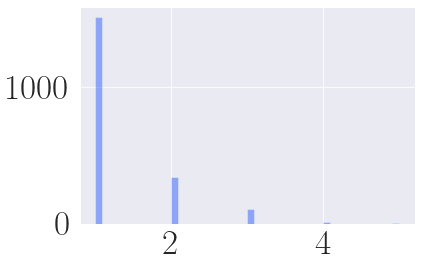

In [199]:
sns.distplot(chain_lengths,norm_hist=False,kde=False)

In [200]:
total_trip_travels = [sum(travel_list) for travel_list in trip_travels]

In [226]:
total_trip_and_pickup_travels = [sum(travel_list) + sum(pickup_list) for (travel_list,pickup_list) in zip(trip_travels,pickup_travels)]
total_trip_and_pickup_travels_matched_only = [sum(travel_list) + sum(pickup_list) for (travel_list,pickup_list) in zip(trip_travels,pickup_travels) if pickup_list]
total_trip_travels_matched_only = [sum(travel_list) for travel_list in trip_travels if len(travel_list) > 1]

In [210]:
total_pickup_times = [sum(time_list) for time_list in pickup_times if time_list]

In [211]:
total_pickup_times

[573.9999999999999,
 85.99999999999973,
 9.00000000000025,
 383.9999999999999,
 82.99999999999964,
 346.0000000000011,
 504.00000000000125,
 66.99999999999973,
 670.9999999999995,
 63.000000000000156,
 207.00000000000017,
 523.0000000000005,
 34.99999999999991,
 282.0000000000015,
 910.9999999999999,
 377.9999999999997,
 180.9999999999997,
 102.99999999999994,
 104.00000000000023,
 834.0,
 5.999999999999365,
 415.9999999999993,
 96.00000000000027,
 273.0,
 211.00000000000054,
 495.99999999999966,
 130.99999999999937,
 100.99999999999974,
 346.999999999999,
 175.99999999999903,
 622.0000000000008,
 236.9999999999998,
 107.00000000000031,
 234.0000000000001,
 71.00000000000011,
 121.00000000000044,
 398.0000000000004,
 62.00000000000066,
 165.9999999999999,
 167.9999999999999,
 101.00000000000014,
 414.00000000000034,
 143.0000000000001,
 210.00000000000105,
 287.0000000000005,
 147.00000000000009,
 899.9999999999994,
 215.9999999999996,
 808.0000000000003,
 340.9999999999996,
 270.99999

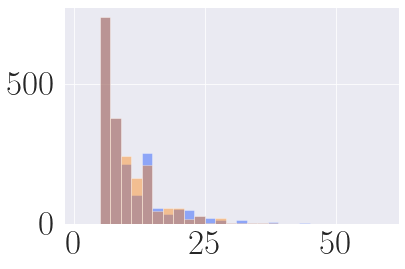

In [217]:
sns.distplot(total_trip_and_pickup_travels, kde=False, bins = range(1,60,2))
sns.distplot(total_trip_travels, kde=False, bins = range(1,60,2))

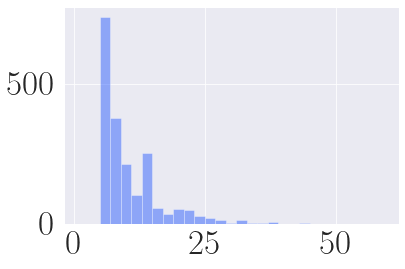

In [225]:
sns.distplot(total_trip_and_pickup_travels, kde=False, bins = range(1,60,2))

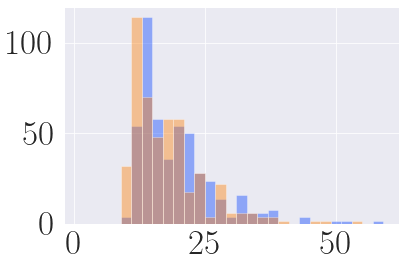

In [227]:
sns.distplot(total_trip_and_pickup_travels_matched_only, kde=False, bins = range(1,60,2))
sns.distplot(total_trip_travels_matched_only, kde=False, bins = range(1,60,2))

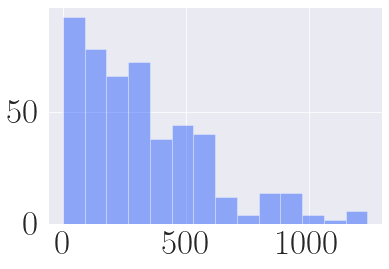

In [212]:
sns.distplot(total_pickup_times,kde=False) #excluding zeros

In [339]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(total_trip_travels,kde=False,bins=20,hist_kws={'align':'left',"alpha":0.7,'width':4.})
ax.set_xlabel("total chain travel (km)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
# ax.set_xticks(range(11))
# ax.set_xlim(0,10)
ax.tick_params(axis='both', which='major', labelsize=18)

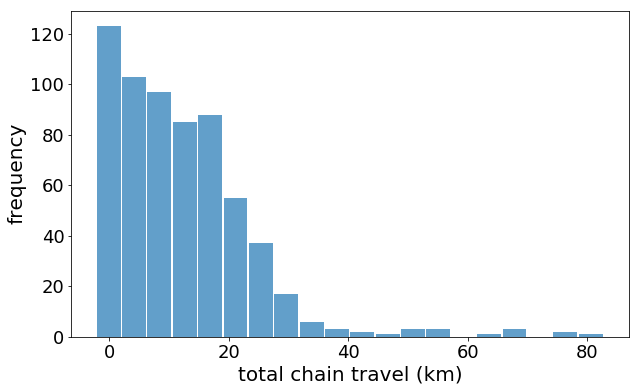

In [340]:
plt.show()

In [304]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(total_trip_travels,hist=False, bins=20,kde_kws={'cumulative':True})
ax.set_xlabel("total chain travel (km)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
# ax.set_xticks(range(11))
# ax.set_xlim(0,10)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.grid()

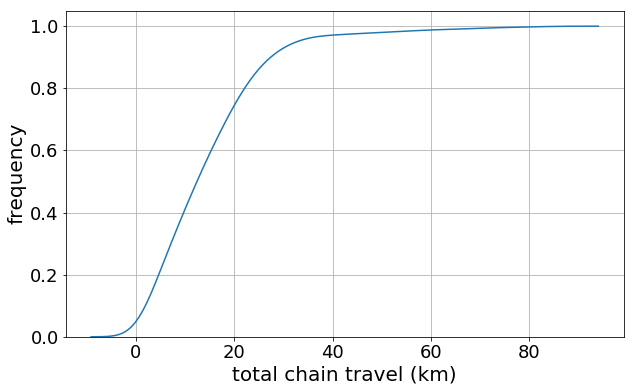

In [305]:
plt.show()

In [278]:
total_pickup_travels = [sum(x)/1000 for x in pickup_travels]

In [331]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(total_pickup_travels,kde=False,bins=[i*0.1 for i in range(90)],hist_kws={'align':'left',"alpha":0.7,'width':0.08})
ax.set_xlabel("total travels to pickup (kms)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
ax.set_xticks(range(11))
# ax.set_xlim(0,10)
ax.tick_params(axis='both', which='major', labelsize=18)

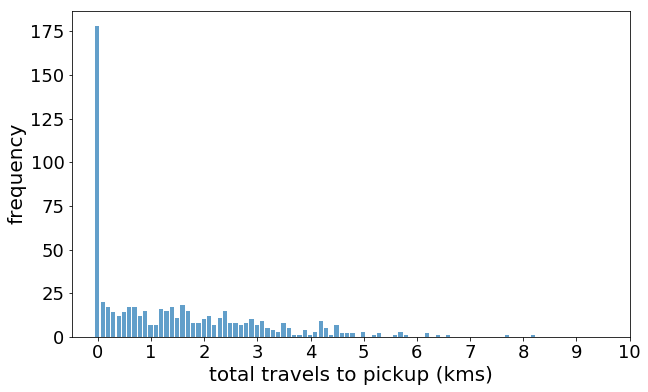

In [332]:
plt.show()

In [349]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(total_pickup_travels,hist=False, bins=20,kde_kws={'cumulative':True})
ax.set_xlabel("total travels to pickup (kms)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
# ax.set_xticks(range(11))
# ax.set_xlim(0,10)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.grid()

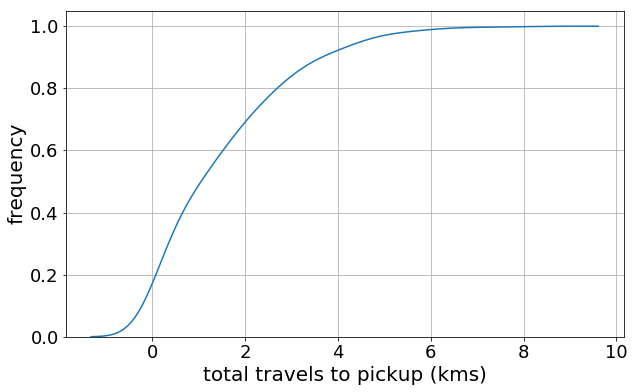

In [350]:
plt.show()

In [351]:
total_pickup_times = [sum(x) for x in pickup_times]

In [352]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(total_pickup_times,kde=False,bins=[60*i for i in range(40)],hist_kws={'align':'left',"alpha":0.7,'width':55})
ax.set_xlabel("total time to pickup (s)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
# ax.set_xticks(range(11))
# ax.set_xlim(0,10)
ax.tick_params(axis='both', which='major', labelsize=18)

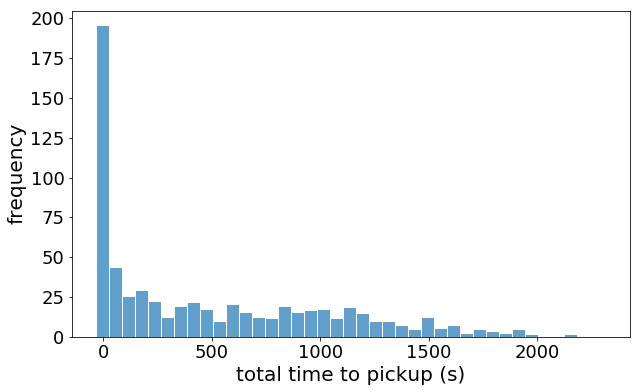

In [353]:
plt.show()

In [354]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(total_pickup_times,hist=False, bins=20,kde_kws={'cumulative':True})
ax.set_xlabel("total time to pickup (s)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
# ax.set_xticks(range(11))
# ax.set_xlim(0,10)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.grid()

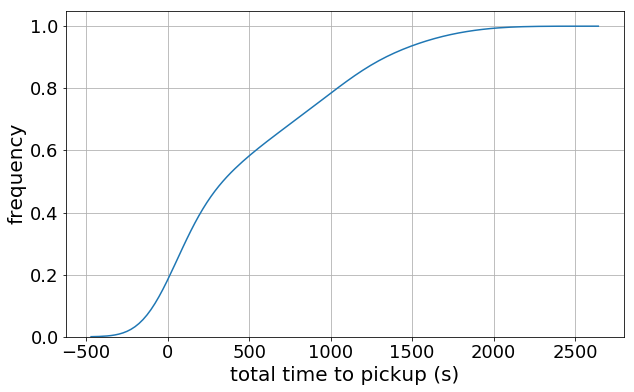

In [355]:
plt.show()